In [1]:
!pip install xgboost==1.2
!pip install pandas-profiling[notebook]
!pip install plotly-express
!pip install snowflake-connector-python[pandas]
!pip install shap

In [100]:
import numpy as np
import pandas as pd
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
from snowflake.connector import pandas_tools as sfpd
import snowflake.connector
import toml
import datetime as dt
import pickle as pkl 
import tarfile
import xgboost
from pandas_profiling import ProfileReport
from sagemaker.analytics import TrainingJobAnalytics
import os, glob, re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px

In [101]:
env = toml.load('config.toml')
conn = snowflake.connector.connect(
                user= env['trial'].get('user'),
                password= env['trial'].get('password'),
                account= env['trial'].get('account'),
                warehouse=env['trial'].get('warehouse'),
                database=env['trial'].get('database'),
                schema=env['trial'].get('schema')
                )

In [102]:
cur = conn.cursor()
sql = "select * from abalone_test;"
cur.execute(sql)
abalone_df = cur.fetch_pandas_all()

In [103]:
abalone_df.head()

SEX  LENGTH  DIAMETER  HEIGHT  WHOLE_WEIGHT  SHUCKED_WEIGHT  VISCERA_WEIGHT  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   SHELL_WEIGHT  RINGS  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

In [104]:
abalone_df['AGE'] = abalone_df['RINGS'] + 1.5
abalone_df.drop('RINGS', axis=1,inplace=True)
abalone_df.head()

SEX  LENGTH  DIAMETER  HEIGHT  WHOLE_WEIGHT  SHUCKED_WEIGHT  VISCERA_WEIGHT  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   SHELL_WEIGHT   AGE  
0         0.150  16.5  
1         0.070   8.5  
2         0.210  10.5  
3         0.155  11.5  
4         0.055   8.5

In [105]:
abalone_profile = ProfileReport(abalone_df, title="Abalone Profiling Report")
abalone_profile

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [106]:
# Specify your bucket name
bucket_name = 'sgang-ml-sagemaker'
training_folder = 'abalone/training/'
validation_folder = 'abalone/validation/'
test_folder = 'abalone/test/'
# s3_model_output_location = r's3://{0}/abalone/model'.format(bucket_name)
s3_model_output_location = f's3://{bucket_name}/abalone/model'
s3_training_file_location = f's3://{bucket_name}/{training_folder}'
s3_validation_file_location = f's3://{bucket_name}/{validation_folder}'
s3_test_file_location = f's3://{bucket_name}/{test_folder}'

In [107]:
print(s3_model_output_location)
print(s3_training_file_location)
print(s3_validation_file_location)
print(s3_test_file_location)

s3://sgang-ml-sagemaker/abalone/model
s3://sgang-ml-sagemaker/abalone/training/
s3://sgang-ml-sagemaker/abalone/validation/
s3://sgang-ml-sagemaker/abalone/test/


In [108]:
def write_to_s3(filename, bucket, key):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(f)

In [109]:
### Shuffle data and split into train/test - in this case lets just do train & val

In [110]:
abalone_shuffle_df = abalone_df.sample(frac=1) #shuffle_data
train_idx = round(len(abalone_shuffle_df)*.7)

In [111]:
train_abalone_df = abalone_shuffle_df[:train_idx]
validation_abalone_df = abalone_shuffle_df[train_idx:]
len(train_abalone_df), len(validation_abalone_df) #split 70-30

(2924, 1253)

In [112]:
columns = list(abalone_df.columns)
y = columns.pop() # extract the dependent var
columns.insert(0,y)
print(f'The following is the list of columns {columns}')

The following is the list of columns ['AGE', 'SEX', 'LENGTH', 'DIAMETER', 'HEIGHT', 'WHOLE_WEIGHT', 'SHUCKED_WEIGHT', 'VISCERA_WEIGHT', 'SHELL_WEIGHT']


In [113]:
# write the entire dataframe locally and let's use this as a proxy for test data if needed later.
train_abalone_df.to_csv('abalone_train.csv',index = False,
                        header = False,columns=columns)
validation_abalone_df.to_csv('abalone_valid.csv',index = False,
                             header = False, columns=columns)
abalone_df.to_csv('abalone_test_full_orig.csv', index=False, header = False, columns =columns)

In [114]:
# Write Column List
with open('abalone_column_list.txt','w') as f:
    f.write(','.join(columns))

#### Write Data to S3

In [115]:
write_to_s3('abalone_train.csv', 
            bucket_name,
            training_folder + 'abalone_train.csv')

write_to_s3('abalone_valid.csv',
            bucket_name,
            validation_folder + 'abalone_validation.csv')

write_to_s3('abalone_test_full_orig.csv',
            bucket_name,
            test_folder + 'abalone_test_full_orig.csv')

In [116]:
sess = sagemaker.Session()
role = get_execution_role()

Pick Algorithm

In [117]:
#from the docs 
# https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_parquet_input_training.html?highlight=xgboost%20container
container = sagemaker.image_uris.retrieve("xgboost",sess.boto_region_name,version="1.2-1")
print (f'Using XGBoost Container {container}')

Using XGBoost Container 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1


#### Set Estimator Settings  - HyperParams, HW Specs, Job Settings & Name

In [118]:
#  ref - https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html
# alternate - use the set_hyperparameters method to attach hyper params
# see here  estimator interface 
# https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/estimator.py

hyperparameters = {
        "max_depth":"5",
        "eta":"0.1",
        "objective":"reg:squarederror",
        "num_round":"150"}

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=hyperparameters,
    instance_type='ml.m4.xlarge',
    output_path=s3_model_output_location,
    sagemaker_session=sess,
    base_job_name = 'abalone-age-v1'
    )

In [119]:
#check to see if this was set right
# can set and toggle hyperparams from here
#https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html

print(f"""INFO: XGBoost OOTB Estimator was passed the following hyper-params:
{toml.dumps(estimator.hyperparam_dict)} 
""")

INFO: XGBoost OOTB Estimator was passed the following hyper-params:
max_depth = "5"
eta = "0.1"
objective = "reg:squarederror"
num_round = "150"
 



#### Set Up input pipes i.e. Data Channel Config

In [120]:
training_input_config = sagemaker.session.TrainingInput(
    s3_data=s3_training_file_location,
    content_type='csv')

validation_input_config = sagemaker.session.TrainingInput(
    s3_data=s3_validation_file_location,
    content_type='csv'
)

data_channels = {'train': training_input_config, 'validation': validation_input_config}

In [121]:
print("INFO: CHECKING TO SEE THE INPUT SETTINGS")
print(f"{toml.dumps(training_input_config.config)}")
print(f"{toml.dumps(validation_input_config.config)}")

INFO: CHECKING TO SEE THE INPUT SETTINGS
ContentType = "csv"

[DataSource.S3DataSource]
S3DataType = "S3Prefix"
S3Uri = "s3://sgang-ml-sagemaker/abalone/training/"
S3DataDistributionType = "FullyReplicated"

ContentType = "csv"

[DataSource.S3DataSource]
S3DataType = "S3Prefix"
S3Uri = "s3://sgang-ml-sagemaker/abalone/validation/"
S3DataDistributionType = "FullyReplicated"



##### Fit the model

In [122]:
os.makedirs('logs',exist_ok=True)

In [124]:
# %%capture --no-stderr run
# print('this is a test')
# with open('testwrite.txt','w') as f:
#     f.write(cap.stdout)

In [125]:
%%capture run --no-stderr
estimator.fit(data_channels)

In [126]:
with open(f"./logs/{dt.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}_trainingjob",'w') as f:
    f.write(run.stdout)

### Download the model from s3 and bring it into the notebook instance

In [127]:
s3_file_name = [i.get('Key') for i in boto3.Session().client('s3').list_objects(Bucket = 'sgang-ml-sagemaker')['Contents']
                if estimator._current_job_name in i.get('Key') and 'model.tar.gz' in i.get('Key')][0]
s3_file_name

'abalone/model/abalone-age-v1-2021-05-19-22-02-23-864/output/model.tar.gz'

In [128]:
s3 = boto3.client('s3')
s3.download_file('sgang-ml-sagemaker',s3_file_name,'abalone_xgb_model.tar.gz')

In [129]:
t = tarfile.open('abalone_xgb_model.tar.gz', 'r:gz')
t.extractall()
model = pkl.load(open('xgboost-model','rb'))

In [130]:
training_job_name = estimator._current_job_name
# metric_name = ['train:rmse','vaidation:rmse']
metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=['train:rmse','validation:rmse']).dataframe()

In [131]:
metrics_dataframe[['metric_name','value']]

metric_name    value
0       train:rmse  1.38693
1  validation:rmse  2.18704

### Track Performance of the ML model across iterations

In [132]:
files= glob.glob('./logs/*trainingjob')  #get the logs
recent_run=max(files,key = os.path.getctime) #find the most recent run
#read the content
with open(recent_run) as f:
    content = f.read()
#parse out metrics
train_metric_blob=content[content.find('train-rmse'):content.lower().find('training seconds')]
train_rmse_idx = [val.end() for val in 
                  re.finditer('train-rmse:',train_metric_blob)]
train_rmse = [float(train_metric_blob[i:i+5]) for i in train_rmse_idx]
valid_metric_blob=content[content.find('validation-rmse'):content.lower().find('training seconds')]
valid_rmse_idx = [val.end() for val in 
                  re.finditer('validation-rmse:',valid_metric_blob)]
valid_rmse = [float(valid_metric_blob[i:i+5]) for i in valid_rmse_idx]

     train_rmse  valid_rmse
0        10.300      10.330
1         9.332       9.372
2         8.459       8.511
3         7.677       7.740
4         6.977       7.055
..          ...         ...
145       1.398       2.185
146       1.393       2.185
147       1.391       2.186
148       1.389       2.186
149       1.386       2.187

[150 rows x 2 columns]


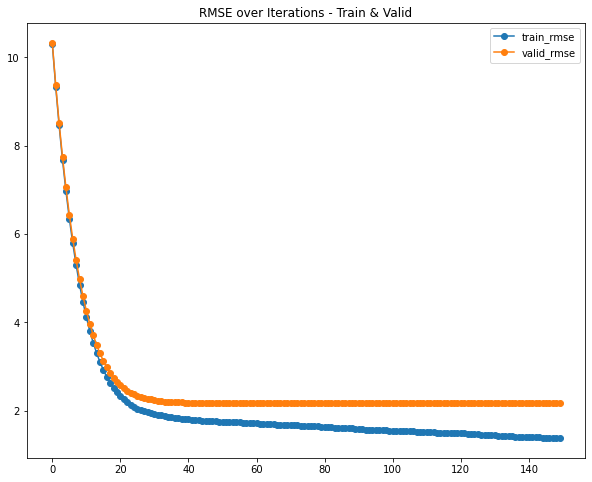

In [133]:
metrics_dict ={'train_rmse':train_rmse,  'valid_rmse':valid_rmse}
iter_metrics = pd.DataFrame(metrics_dict, columns=['train_rmse','valid_rmse'])
print(iter_metrics[['train_rmse','valid_rmse']])
iter_metrics[['train_rmse','valid_rmse']].plot(kind='line', figsize=(10,8), 
                                               title = 'RMSE over Iterations - Train & Valid', marker = "o");

In [134]:
import shap

In [135]:
X = abalone_df.iloc[:,:-1]

In [136]:
X.head()

SEX  LENGTH  DIAMETER  HEIGHT  WHOLE_WEIGHT  SHUCKED_WEIGHT  VISCERA_WEIGHT  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   SHELL_WEIGHT  
0         0.150  
1         0.070  
2         0.210  
3         0.155  
4         0.055

In [137]:
X['SEX'] = X['SEX'].astype('category')
X['SEX'] = X['SEX'].cat.codes # Level Encode
X.head()

SEX  LENGTH  DIAMETER  HEIGHT  WHOLE_WEIGHT  SHUCKED_WEIGHT  \
0    2   0.455     0.365   0.095        0.5140          0.2245   
1    2   0.350     0.265   0.090        0.2255          0.0995   
2    0   0.530     0.420   0.135        0.6770          0.2565   
3    2   0.440     0.365   0.125        0.5160          0.2155   
4    1   0.330     0.255   0.080        0.2050          0.0895   

   VISCERA_WEIGHT  SHELL_WEIGHT  
0          0.1010         0.150  
1          0.0485         0.070  
2          0.1415         0.210  
3          0.1140         0.155  
4          0.0395         0.055

In [140]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

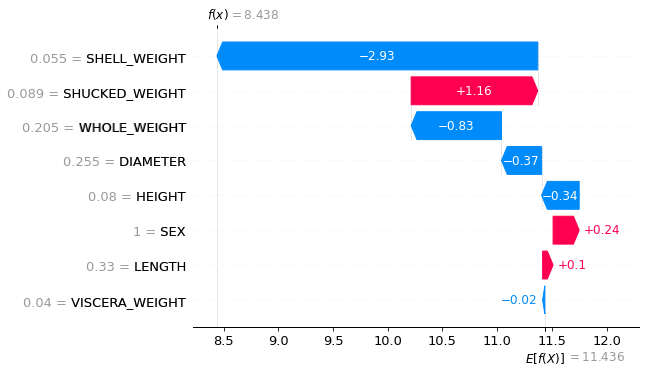

In [166]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[4])

In [164]:
abalone_df.head()

SEX  LENGTH  DIAMETER  HEIGHT  WHOLE_WEIGHT  SHUCKED_WEIGHT  VISCERA_WEIGHT  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   SHELL_WEIGHT   AGE  
0         0.150  16.5  
1         0.070   8.5  
2         0.210  10.5  
3         0.155  11.5  
4         0.055   8.5

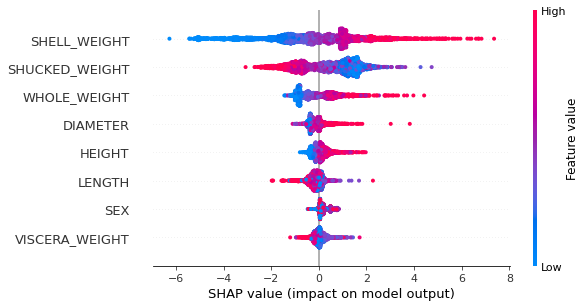

In [150]:
# shap.initjs()
shap.summary_plot(shap_values)

SHUCKED_WEIGHT    665
SHELL_WEIGHT      611
LENGTH            550
WHOLE_WEIGHT      497
VISCERA_WEIGHT    427
HEIGHT            331
DIAMETER          302
SEX               134
dtype: int64


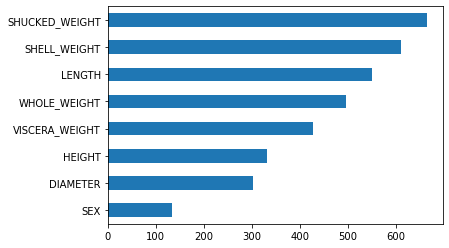

In [152]:
# Variable Importance based on Split Strength
if model.booster=='gbtree':
    model_fscore = model.get_fscore()
#     print(model_fscore)
    lookup_dict = {f'f{i[0]}':i[1] for i in enumerate(columns[1:])}
    feature_importances={lookup_dict[i]:model_fscore[i] for i in model_fscore.keys()}
    print(pd.Series(feature_importances).sort_values(ascending=False))
    pd.Series(feature_importances).sort_values(ascending=True).plot(kind = 'barh');
else:
    print('exception!')

In [153]:
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type='ml.m4.xlarge',
                             endpoint_name = 'xgboost-abalone-v1')

-------------------!

In [167]:
## Next we need confirmation that we're making the right predictions

from sagemaker.serializers import CSVSerializer
predictor.serializer = CSVSerializer()

In [168]:
X.iloc[4].values

array([1.    , 0.33  , 0.255 , 0.08  , 0.205 , 0.0895, 0.0395, 0.055 ])

In [169]:
predictor.predict([[1., 0.33  , 0.255 , 0.08  , 0.205 , 0.0895, 0.0395, 0.055]])

b'8.438337326049805'